# Does Icing the Kicker Work?

There is a prevailing belief by NFL fans and coaches that "icing" the kicker, or the opposing team taking a timeout to stretch out the dead time before the a field goal attempt, makes the kicker less likely to complete the field goal. Does the data support this belief?

NFL regular season play-by-play data from 2009-2019 will be used in this analysis.

## Setup

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

sns.set_style('whitegrid')

In [2]:
# load the data from 2009-2018
nfl_path = r"C:\Users\pschl\OneDrive\Documents\data_science\NFL\NFL Play by Play 2009-2018 (v5).csv"
nfl_df = pd.read_csv(nfl_path)

C:\Users\pschl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
nfl_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [4]:
nfl_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449371 entries, 0 to 449370
Data columns (total 255 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   play_id                               int64  
 1   game_id                               int64  
 2   home_team                             object 
 3   away_team                             object 
 4   posteam                               object 
 5   posteam_type                          object 
 6   defteam                               object 
 7   side_of_field                         object 
 8   yardline_100                          float64
 9   game_date                             object 
 10  quarter_seconds_remaining             float64
 11  half_seconds_remaining                float64
 12  game_seconds_remaining                float64
 13  game_half                             object 
 14  quarter_end                           int64  
 15  drive           

Concatenate 2019 data to dataframe. Load it and check for consistent columns:

In [5]:
nfl_2019_df = pd.read_csv(r"C:\Users\pschl\OneDrive\Documents\data_science\NFL\reg_pbp_2019.csv")
nfl_2019_df.shape

C:\Users\pschl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (167,168,169,170,175,176,179,180,183,184,189,190,191,192,195,196,204,205,206,219,220,221,222,223,224,227,228,232,233,234,239,241,242) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(45546, 256)

There is one additional column in the 2019 dataframe. Find it and drop it from the 2019 data:

In [6]:
# find which column in the 2019 data not contained in the 2009-2018 data
cols_in_df = set(nfl_df.columns.tolist())
cols_in_2019 = set(nfl_2019_df.columns.tolist())
diff = cols_in_2019.difference(cols_in_df)
print(diff)

{'touchback'}


In [7]:
# remove column from 2019 dataset
nfl_2019_df.drop(columns=['touchback'], inplace=True)
# concatenate the data
nfl_df = nfl_df.append(nfl_2019_df).reset_index(drop=True)
nfl_df.shape

(494917, 255)

Games can span multiple calendar years depending on the season, so an additional column will be added for convenience to filter by individual seasons.

In [8]:
# convert game_date to datetime
nfl_df['game_date'] = pd.to_datetime(nfl_df['game_date'])

In [9]:
# create new column for the current season
def get_season(game_date):
    if game_date.month <= 3: # end of year or postseason
        return game_date.year - 1
    else: # fall games
        return game_date.year
    
nfl_df['season'] = nfl_df['game_date'].apply(get_season)

Examine the field goal result column:

In [10]:
nfl_df['field_goal_result'].value_counts()

made       9028
missed     1544
blocked     224
Name: field_goal_result, dtype: int64

Create a new column that groups together missed and blocked (both are unsuccessful).

In [11]:
def map_field_goal_success(df):
    # maps the field_goal_result column from 'made', 'missed', 'blocked' into
    # success (=1) or failure (=0)
    # - Returns the modified DataFrame with new column 'field_goal_successful'
    fg_map = {'made': 1, 'missed': 0, 'blocked': 0}
    df['field_goal_successful'] = df['field_goal_result'].replace(fg_map)
    return df

In [12]:
# map field goal descriptive result into success and failure in new 'field_goal_successful' column
nfl_df = map_field_goal_success(nfl_df)

# Analysis

## Field goal statistics in pressure situations

Pressure field goals, or high-consequence attempts, are defined as follows:

1. **Low time remaining:** <3:00 remaining in the 4th quarter, or anytime in overtime (sudden death)
2. **Game-altering outcome:** team attempting the kick will either tie or take the lead

Looking at this restrictive subset of cases, rather than timeout vs. no-timeout prior to the kick at any point in the game, attempts to control for the effect of pressure/nerves. For example, an attempt with 10:00 remaining in the 1st quarter is a much less consequential situation than the final play of the game determining a win or loss, even though the underlying mechanics of the attempt is the same. Likewise, occasionally icing happens in the closing minutes of the first half due to the use-it-or-lose-it mechanism for timeouts between halfs; however, the consequences of make/miss and the resulting pressure of the situation is less significant with an additional half left to play.

There are also cases where an accepted penalty (delay of game, false start, offsides, encroachment, etc.) occurs directly before a kick, causing a disruption in game flow equivalent to a timeout. For the purposes of this analysis, accepted penalties have the same delay effect as a timeout, and both will be considered as an "iced" kick.

In [13]:
pres_kicks = ((nfl_df['field_goal_attempt'] == 1)  # field goal attempted
             & (   ((nfl_df['qtr'] == 4) & (nfl_df['quarter_seconds_remaining'] <= 180))  # 4th quarter, <3:00
                 | (nfl_df['qtr'] == 5)  # overtime
               )
             & (nfl_df['score_differential'] >= -3) & (nfl_df['score_differential'] <= 0) # to tie or take the lead
             )

pres_kicks_df = nfl_df[pres_kicks].copy()
pres_kicks_df.shape

(530, 257)

There are 530 pressure kicks over the 2009-2019 seasons. They need to be further separated by the presence of a disruptive delay before the kick (penalty or opposing team timeout). 

Note: the plays in the entire dataset are in chronological order within each game, so using the index directly before the kick is the play immediately prior to the kick. This was confirmed while doing this analysis, but it is not shown.

In [14]:
# get the plays directly before the pressure kicks
prev_plays_df = nfl_df.loc[pres_kicks_df.index-1].copy()
# define an iced kick as (1) the opposing team called a time out, or (2) there was a penalty before the kick
pres_kicks_df['iced'] = (
                            # opposing team timeout
                          ((prev_plays_df['timeout'] == 1) & (prev_plays_df['defteam'] == prev_plays_df['timeout_team']))
                         |  # or penalty disrupting the flow of the game
                          (prev_plays_df['penalty'] == 1)
                        ).tolist()
print('Iced FG Attempts:')
pres_kicks_df['iced'].value_counts()

Iced FG Attempts:


False    368
True     162
Name: iced, dtype: int64

There is slight imbalance, but there are still quite a few instances of icing. Icing occurences are expected to be less because it is not a consensus strategy, and some situations prevent icing from taking place. For example, if the opposing team does not have any timeouts remaining, it is impossible to ice the kicker, stoppage penalties excluded.

In [15]:
print(f"opposing team timeouts: {((prev_plays_df['timeout'] == 1) & (prev_plays_df['defteam'] == prev_plays_df['timeout_team'])).sum()}")
print(f"previous play penalties: {(prev_plays_df['penalty'] == 1).sum()}")

opposing team timeouts: 140
previous play penalties: 22


The vast majority of the icing situations are from timeouts instead of penalties.

Iced Ratio by Score Differential:

                    iced_ratio  count
score_differential                   
-3.0                  0.198020    101
-2.0                  0.382353     68
-1.0                  0.333333     93
 0.0                  0.317164    268


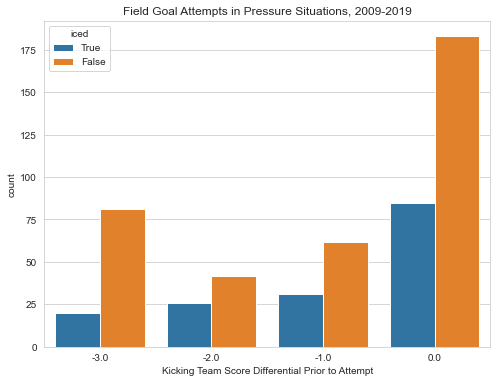

In [16]:
# counts by game situation: points behind, stratified by icing situations
f=plt.figure(figsize=(8,6))
ax=f.gca()
sns.countplot(data=pres_kicks_df, x='score_differential', hue='iced', hue_order=[True, False], ax=ax)
ax.set_title('Field Goal Attempts in Pressure Situations, 2009-2019')
ax.set_xlabel('Kicking Team Score Differential Prior to Attempt')

print('Iced Ratio by Score Differential:')
print()
print(pres_kicks_df.groupby('score_differential').agg(iced_ratio=('iced','mean'),
                                                      count=('score_differential','size')).sort_index(ascending=True))

From the table above, it appears that icing occurs at a rate >50% higher when the attempt would produce a lead change (score differential >= -2), compared to tying (score differential = -3). This makes intuitive sense from the defending team's risk management point of view; the worst case scenario is equalizing the game. If enough time is left on the clock, timeouts are more useful for the upcoming drive on offense to take back the lead. Icing in a -3 score differential scenario only makes tactical sense either for time preservation to prevent the 40-second game clock runoff, or remaining timeouts have no other purpose like last play of the game.

### Pressure Icing vs. Non-Icing in Aggregate

In [17]:
# print accuracy data
print('Accuracy by Iced:')
print()
print(pres_kicks_df.groupby(['iced']).agg(fg_accuracy=('field_goal_successful','mean'),
                                         avg_distance=('kick_distance','mean')))
print()

Accuracy by Iced:

       fg_accuracy  avg_distance
iced                            
False     0.774457     39.964674
True      0.740741     41.222222



Iced kicks have a 3.3% lower success rate than non-iced kicks. Is this statistically significant?

In [18]:
# test of iced attempts have a lower accuracy rate than non-iced (1-sided proportion z-test)
pres_kicks_data = pres_kicks_df.groupby('iced').agg(made=('field_goal_successful', np.sum),
                                                 attempted=('field_goal_successful', 'size')).sort_index(ascending=False)
print(pres_kicks_data)
print()

# test hypothesis that accuracy(icing) < accuracy(non-icing)
_, p_val = proportions_ztest(pres_kicks_data.made, pres_kicks_data.attempted, alternative='smaller')
print(f'Iced accuracy 1-sided test (icing < non-icing) p-value: {p_val:.3f}')

        made  attempted
iced                   
True   120.0        162
False  285.0        368

Iced accuracy 1-sided test (icing < non-icing) p-value: 0.200


The p-value shows that as a broad strategy, we can't prove a statistically significant advantage for icing at a confidence level of 5%. It is also important to note the average distance for the non-iced kicks is 1 yard closer than iced.

Even if the success rate difference was statistically significant, the effect on win probability of using a timeout to ice the kicker vs. the value of saving it for use on the next drive could be the subject of another analysis.

If icing as a broad strategy is not conclusively effective, are there specific situations (i.e. score, distance) where icing produces a larger effect?

### Accuracy vs. Scoring Differential

One variable in pressure situations is the the score (or score differential) at the time of the kick.

In [19]:
def plot_fg_accuracy_iced(df, strat_col, figsize=(8,6), ylim=[0,1]):
    # create figure and plots barplot. Returns matplotlib Axes object
    f=plt.figure(figsize=(8,6))
    ax=f.gca()
    sns.barplot(data=df, 
                x=strat_col, 
                y='field_goal_successful', 
                hue='iced', 
                hue_order=[True,False], 
                ax=ax)
    ax.set_title('Field Goal Accuracy in Pressure Situations, 2009-2019')
    ax.set_ylabel('FG Accuracy')
    ax.set_ylim(ylim);
    # xlabel is left unset for user to modify
    return ax

Accuracy by Score Differential:

                          fg_accuracy
score_differential iced              
-3.0               False     0.814815
                   True      0.750000
-2.0               False     0.666667
                   True      0.615385
-1.0               False     0.822581
                   True      0.774194
 0.0               False     0.765027
                   True      0.764706


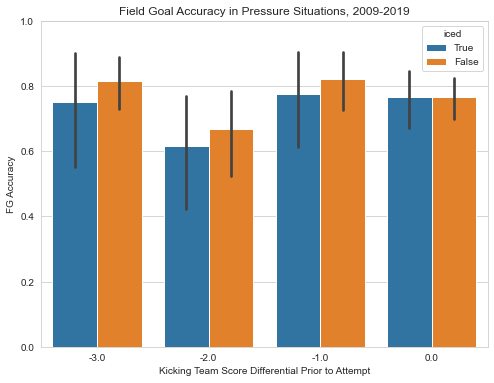

In [20]:
# plot accuracy rate stratified by score differential and iced/non-iced
ax = plot_fg_accuracy_iced(pres_kicks_df, 'score_differential')
ax.set_xlabel('Kicking Team Score Differential Prior to Attempt')

print('Accuracy by Score Differential:')
print()
print(pres_kicks_df.groupby(['score_differential', 'iced'])
      .agg(fg_accuracy=('field_goal_successful','mean'))
      .sort_index(ascending=True))

In aggregate and split out by score differential, it appears that icing the kicker does decrease the accuracy rate about 5% when the kicking team is behind, and no effect when the kicking team is ahead. However, the difference not much larger than icing in aggregate.

### Accuracy vs. Distance

To evaluate the effect of distance on iced attempts in pressure situations, field goal distances should be grouped into ranges due to the relatively low number of pressure attempts in our dataset when split by individual distances. The success rate for all field goals from 2009-2019 in all game situations is shown below, along with a 3rd order polynomial fit.

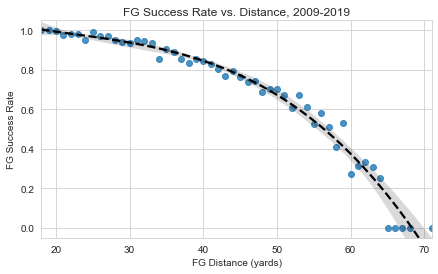

In [21]:
# scatterplot of FG accuracy by distance
fg_gb = (nfl_df.loc[nfl_df['field_goal_attempt']==1, ['field_goal_successful', 'kick_distance']]
         .groupby('kick_distance').mean()
         .reset_index())
f = plt.figure(figsize=(7,4))
ax = f.gca()
sns.regplot(data=fg_gb, x='kick_distance', y='field_goal_successful',
            order=3,
            line_kws={'color': 'black', 'ls':'--'},
            ax=ax)
ax.set_xlabel('FG Distance (yards)')
ax.set_ylabel('FG Success Rate')
ax.set_ylim([-.05, 1.05])
ax.set_title('FG Success Rate vs. Distance, 2009-2019');

A good rule of thumb for NFL kickers is <30 yards is almost an automatic success, 30-40 yards is easy, 40-50 yards is more difficult especially in poor conditions, and 50+ yards is difficult. This generalization is supported by the plot above. First we need to confirm that the pressure kick data has a enough kicks support this grouping scheme:

count    530.000000
mean      40.349057
std       10.532731
min       18.000000
25%       32.000000
50%       41.000000
75%       48.000000
max       68.000000
Name: kick_distance, dtype: float64

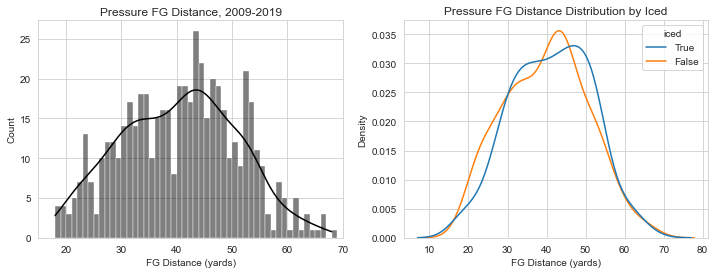

In [22]:
# histogram by field goal distance for each pressure attempt
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.histplot(data=pres_kicks_df, x='kick_distance', bins=range(70),
             kde=True, ax=ax1, color='black')
ax1.set_xlabel('FG Distance (yards)')
ax1.set_xlim([15, 70])
ax1.set_title('Pressure FG Distance, 2009-2019')
# pressure kicks stratified by icing
sns.kdeplot(data=pres_kicks_df, x='kick_distance', hue='iced',
            hue_order=[True, False], common_norm=False, ax=ax2)
ax2.set_xlabel('FG Distance (yards)')
ax2.set_title('Pressure FG Distance Distribution by Iced')

pres_kicks_df['kick_distance'].describe()

The low counts at any given distance confirms the need for grouping. The smallest possible value is 18 yards, so the minimum is valid (10 yards to goal posts at the back of the endzone + 1 yard line + 7 yards offset from line of scrimmage to the kick location). The current NFL record for a successful field goal is 64 yards, although teams have on rare occasions attempted further distances when there is no other viable option and there is no consequence for a miss, for example on the last play of the first half. So a maximum of 68 yards is also reasonable.

Looking at the iced vs. non-iced distributions in the right plot, both are very similar. The plot implies that the distance distribution is a minor factor in the previous aggregate iced vs. non-iced analysis done earlier.

Bin the data into groups:

* <30 yards
* 30-39 yards
* 40-49 yards
* 50+ yards

In [23]:
def bin_fg_distance(df):
    # returns a Series with binned field goal distances
    bins = [0, 30, 40, 50, float('inf')]  # pd.cut() is left-bound inclusive with right=False flag
    labels = ['<30', '30-39', '40-49', '50+']
    return pd.cut(df['kick_distance'], 
                  bins=bins, 
                  labels=labels,
                  right=False)

In [24]:
# bin the field goal attempt distances
pres_kicks_df['kick_distance_bin'] = bin_fg_distance(pres_kicks_df)

# show bin counts
pres_kicks_df['kick_distance_bin'].value_counts().sort_index()

<30       90
30-39    146
40-49    183
50+      111
Name: kick_distance_bin, dtype: int64

The grouped data has relatively balanced counts, which is sufficient for this analysis.

Iced Ratio by Score Differential:

                   iced_ratio  count
kick_distance_bin                   
<30                  0.233333     90
30-39                0.335616    146
40-49                0.284153    183
50+                  0.360360    111

Accuracy by FG Distance:

                         fg_accuracy
kick_distance_bin iced              
<30               False     0.942029
                  True      0.952381
30-39             False     0.948454
                  True      0.918367
40-49             False     0.732824
                  True      0.692308
50+               False     0.450704
                  True      0.475000


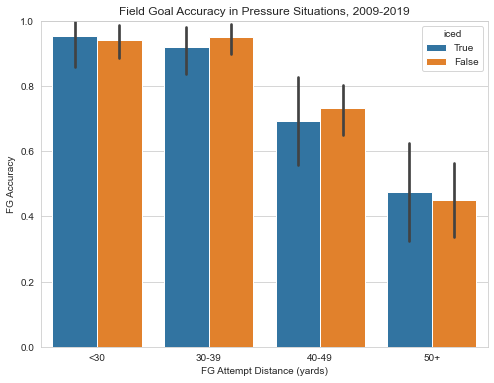

In [25]:
# plot accuracy stratified by kicking distance and iced/not iced
ax = plot_fg_accuracy_iced(pres_kicks_df, 'kick_distance_bin')
ax.set_xlabel('FG Attempt Distance (yards)')

# print iced ratio values for each distance bin
print('Iced Ratio by Score Differential:')
print()
print(pres_kicks_df.groupby('kick_distance_bin')
      .agg(iced_ratio=('iced','mean'), count=('kick_distance_bin','size'))
      .sort_index(ascending=True))
print()

# print accuracy values
print('Accuracy by FG Distance:')
print()
print(pres_kicks_df.groupby(['kick_distance_bin', 'iced'])
      .agg(fg_accuracy=('field_goal_successful','mean'))
      .sort_index(ascending=True))

As expected, there is an inverse relationship between field goal accuracy and distance. However, there does not appear to be a significant difference in success rate when comparing iced attempts vs. non-iced attempts within distance groups, similar to score differential.

## Does Pressure Even Matter?

The analysis above shows that with this data, there is not conclusive evidence that icing the kicker provides a significant advantage in any scenario. The strategy is based on the assumption that increasing the pressure on the kicker will make them more likely to miss; do kickers actually have a lower accuracy rate in pressure situations? If not, the fundamental assumption behind the strategy is flawed.

The effect of pressure can be quantified by comparing the pressure field goal data extracted earlier to the rest of the field goals in the dataset (which are therefore non-pressure situations).

In [26]:
# get the field goals that are not in pressure situations
nopres_kicks_df = (nfl_df.loc[nfl_df['field_goal_attempt']==1,:]
                   .drop(index=pres_kicks_df.index)
                   .copy())
# add the binned kick distance
nopres_kicks_df['kick_distance_bin'] = bin_fg_distance(nopres_kicks_df)

Overall accuracy in pressure vs. non-pressure situations:

In [27]:
pres_summary = pd.DataFrame({'Count': [pres_kicks_df.shape[0], nopres_kicks_df.shape[0]],
              'Accuracy': [pres_kicks_df['field_goal_successful'].mean(), nopres_kicks_df['field_goal_successful'].mean()]},
             index=['Pressure', 'No Pressure'])

pres_summary

,Count,Accuracy
Pressure,530,0.764151
No Pressure,10266,0.839957


There is a 7.5% accuracy difference in pressure vs. no pressure scenarios. Test if this difference is statistically significant at the 5% level:

In [28]:
# 1-sided z-test (pressure accuracy < no pressure accuracy)
made_count = np.round(pres_summary['Accuracy'] * pres_summary['Count'])
_, p_value = proportions_ztest(made_count, pres_summary['Count'], alternative='smaller')
print(f'Pressure accuracy < no pressure test of proportion equality, p-value: {p_value:.2e}')

Pressure accuracy < no pressure test of proportion equality, p-value: 2.13e-06


The p-value indicates the difference between the pressure and non-pressure kick success rate is statistically significant. Therefore pressure does make a kicker less likely to make a field goal.

Does this trend hold of pressure affecting accuracy rates at different distances?

Accuracy by FG Distance:

                                 fg_accuracy
kick_distance_bin pressure_kick             
<30               False             0.973022
                  True              0.944444
30-39             False             0.893048
                  True              0.938356
40-49             False             0.768158
                  True              0.721311
50+               False             0.630299
                  True              0.459459


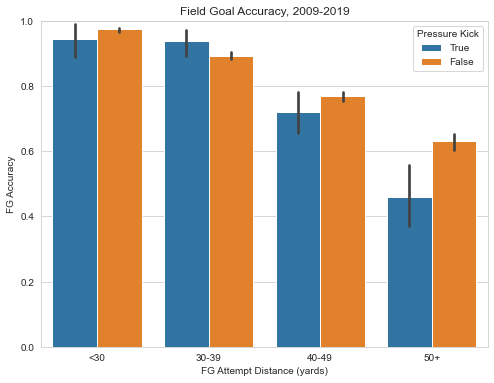

In [29]:
# add a pressure indicator to each dataframe
pres_kicks_df['pressure_kick'] = True
nopres_kicks_df['pressure_kick'] = False
# combine these two dataframes together
all_kicks_df = pd.concat([pres_kicks_df, nopres_kicks_df]).sort_index()

# print accuracy values
print('Accuracy by FG Distance:')
print()
print(all_kicks_df.groupby(['kick_distance_bin', 'pressure_kick'])
      .agg(fg_accuracy=('field_goal_successful','mean'))
      .sort_index(ascending=True))

# plot accuracy rates by distance, stratified by pressure
f=plt.figure(figsize=(8,6))
ax=f.gca()
sns.barplot(data=all_kicks_df, 
            x='kick_distance_bin', 
            y='field_goal_successful', 
            hue='pressure_kick', 
            hue_order=[True,False], 
            ax=ax)
ax.set_title('Field Goal Accuracy, 2009-2019')
ax.set_ylabel('FG Accuracy')
ax.set_ylim([0,1]);
ax.set_xlabel('FG Attempt Distance (yards)')
ax.legend(title='Pressure Kick');

The trend on the non-pressure kicks is steadily decreasing accuracy with increasing distance, as expected. However, it is interesting to see the accuracy rate has a much more substantial drop with increasing distance, and the accuracy rate for 50+ yards is significantly lower than non-pressure 50+ yard attempts (17%).

# Conclusion

Based on this data, there is not evidence to support the belief that icing the kicker improves the chance of winning in any significant way, even in specific game scenarios and kick distances. However, it does appear that pressure does hurt accuracy for kicks >50 yards. This is useful knowledge for the offensive team, especially to determine 4th down decisions in these situations (4th quarter <3:00 or overtime, tied or down by <= 3 points).

## Future work

The play-by-play data used in this study does not provide enough data to differentiate between cases where the kicker has an invalidated kick result due to the timing of a timeout or penalty, effectively giving the kickers a practice attempt on the field. This is also a specific icing strategy, but its effectiveness has been debated relative to traditional icing. This differences in scenarios (practice kick, different ball) has not been accounted for or explored in this analysis and may affect the aggregate results by not blocking for each scenario.